# Resampling MotionSense to 20Hz with Gravity - Multiplying acc by 9.81m/s²


In [1]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.append("../../../")

In [2]:
from pathlib import Path

import numpy as np
import pandas as pd

from librep.utils.dataset import PandasDatasetsIO          # For quick load train, test and validation CSVs
from librep.datasets.multimodal import PandasMultiModalDataset # Wrap CSVs to librep's `Dataset` interface

from librep.datasets.multimodal import TransformMultiModalDataset
from librep.transforms.resampler import SimpleResampler

2022-10-14 17:20:00.120668: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-14 17:20:00.120700: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Loading data

In [3]:
# Path for MotionSense balanced view with the same activities (and labels numbers) as MotionSense
# It is assumed that the directory will contain (train.csv, test.csv and validation.csv)
motionsense_dataset_path = Path("../../../data_2/views/MotionSense/balanced_view")

Once paths is defined, we can load the CSV as pandas dataframes

In [4]:
# Motionsense dataframes
ms_train, ms_validation, ms_test = PandasDatasetsIO(motionsense_dataset_path).load()

Letś take a look in the train dataframes

In [5]:
ms_train.head()

,Unnamed: 0,attitude.roll-0,attitude.roll-1,attitude.roll-2,attitude.roll-3,attitude.roll-4,attitude.roll-5,attitude.roll-6,attitude.roll-7,attitude.roll-8,...,userAcceleration.z-145,userAcceleration.z-146,userAcceleration.z-147,userAcceleration.z-148,userAcceleration.z-149,activity code,length,trial_code,index,user
0,0,1.962846,1.921332,1.877961,1.828619,1.773968,1.719602,1.665240,1.616507,1.579558,...,-0.076770,-0.410893,-0.349788,0.020158,0.236074,0,150,1,150,11
1,1,-0.458128,-0.503994,-0.525220,-0.556961,-0.619681,-0.728183,-0.844220,-0.937235,-1.018289,...,0.080776,0.209356,0.045844,-0.171495,-0.279159,0,150,1,900,12
2,2,0.854208,0.887741,0.945390,1.018196,1.072981,1.099024,1.117173,1.145710,1.176665,...,0.143923,0.035212,-0.023136,-0.038015,0.040352,0,150,1,1050,21
3,3,1.030491,1.065353,1.093455,1.097724,1.071357,1.038327,1.004383,0.972705,0.970985,...,-0.183913,-0.296363,-0.286543,-0.514901,-0.449945,0,150,2,150,17
4,4,-2.674791,-2.548334,-2.361486,-2.109103,-1.826062,-1.564544,-1.341344,-1.179871,-1.083587,...,0.060069,-0.048874,-0.267644,-0.392915,-0.291261,0,150,11,450,21


Summing the gravity component and multiplying accelerometer by 9.81m/s²

In [6]:
for i in range(150):
    ms_train["userAcceleration.x-{}".format(i)] = (ms_train["userAcceleration.x-{}".format(i)] + ms_train["gravity.x-{}".format(i)])*9.81
    ms_train["userAcceleration.y-{}".format(i)] = (ms_train["userAcceleration.y-{}".format(i)] + ms_train["gravity.y-{}".format(i)])*9.81
    ms_train["userAcceleration.z-{}".format(i)] = (ms_train["userAcceleration.z-{}".format(i)] + ms_train["gravity.z-{}".format(i)])*9.81
    ms_validation["userAcceleration.x-{}".format(i)] = (ms_validation["userAcceleration.x-{}".format(i)] + ms_validation["gravity.x-{}".format(i)])*9.81
    ms_validation["userAcceleration.y-{}".format(i)] = (ms_validation["userAcceleration.y-{}".format(i)] + ms_validation["gravity.y-{}".format(i)])*9.81
    ms_validation["userAcceleration.z-{}".format(i)] = (ms_validation["userAcceleration.z-{}".format(i)] + ms_validation["gravity.z-{}".format(i)])*9.81
    ms_test["userAcceleration.x-{}".format(i)] = (ms_test["userAcceleration.x-{}".format(i)] + ms_test["gravity.x-{}".format(i)])*9.81
    ms_test["userAcceleration.y-{}".format(i)] = (ms_test["userAcceleration.y-{}".format(i)] + ms_test["gravity.y-{}".format(i)])*9.81
    ms_test["userAcceleration.z-{}".format(i)] = (ms_test["userAcceleration.z-{}".format(i)] + ms_test["gravity.z-{}".format(i)])*9.81
    

    
    

## Creating librep dataset 

In [7]:
# Motionsense features to select
features = [
    "userAcceleration.x",
    "userAcceleration.y",
    "userAcceleration.z",    
    "rotationRate.x",
    "rotationRate.y",
    "rotationRate.z"
]

# Creating the datasets

# Train
ms_train_dataset = PandasMultiModalDataset(
    ms_train,
    feature_prefixes=features,
    label_columns="activity code",
    as_array=True
)

# Validation
ms_validation_dataset = PandasMultiModalDataset(
    ms_validation,
    feature_prefixes=features,
    label_columns="activity code",
    as_array=True
)

# Test
ms_test_dataset = PandasMultiModalDataset(
    ms_test,
    feature_prefixes=features,
    label_columns="activity code",
    as_array=True
)

In [8]:
ms_train_dataset

PandasMultiModalDataset: samples=3414, features=900, no. window=6, label_columns='activity code'

## Inspect the sample

In [9]:
# Lets print the first sample of ms_train dataset.
# Is a tuple, with an vector of 900 elements as first element and the label as second
#x = ms_train_dataset[0]
#print(x)

# Inspecting sample
# print(f"The sample 0: {x[0]}")
# print(f"Shape of sample 0: {x[0].shape}")
# print(f"The label of sample 0: {x[1]}")

## Checking the window

In [10]:
print(f"MotionSense train have {ms_train_dataset.num_windows} windows")
print(f"Each sample train can be sliced at: {ms_train_dataset.window_slices}")
print(f"Each slice has the following name associated: {ms_train_dataset.window_names}")

MotionSense train have 6 windows
Each sample train can be sliced at: [(0, 150), (150, 300), (300, 450), (450, 600), (600, 750), (750, 900)]
Each slice has the following name associated: ['userAcceleration.x', 'userAcceleration.y', 'userAcceleration.z', 'rotationRate.x', 'rotationRate.y', 'rotationRate.z']


## Activities dictionary

In [11]:
act_names = ['dws',
             'ups',
             'sit',
             'std',
             'wlk',
             'jog']

In [12]:
act_dict = {}
for i in range(0, len(act_names)):
    act_dict[act_names[i]] = i

## Resampling

### Setting the column names

In [13]:
accel_x = ["userAcceleration.x-"+str(i) for i in range(0, 60)]
accel_y = ["userAcceleration.y-"+str(i) for i in range(0, 60)]
accel_z = ["userAcceleration.z-"+str(i) for i in range(0, 60)]
gyro_x = ["rotationRate.x-"+str(i) for i in range(0, 60)]
gyro_y = ["rotationRate.y-"+str(i) for i in range(0, 60)]
gyro_z = ["rotationRate.z-"+str(i) for i in range(0, 60)]
columns = np.concatenate((accel_x, accel_y, accel_z, gyro_x, gyro_y, gyro_z))

### Creating the resampled dataframes

In [14]:
resampler = SimpleResampler(new_sample_size=60)
transformer = TransformMultiModalDataset(transforms=[resampler], new_window_name_prefix="resampled-20Hz.")

In [15]:
resampled_ms_train_samples_df = pd.DataFrame(transformer(ms_train_dataset)[:][0], columns=columns)
resampled_ms_train = pd.concat([resampled_ms_train_samples_df, ms_train.iloc[:, -5:]], axis=1)

resampled_ms_validation_samples_df = pd.DataFrame(transformer(ms_validation_dataset)[:][0], columns=columns)
resampled_ms_validation = pd.concat([resampled_ms_validation_samples_df, ms_validation.iloc[:, -5:]], axis=1)

resampled_ms_test_samples_df = pd.DataFrame(transformer(ms_test_dataset)[:][0], columns=columns)
resampled_ms_test = pd.concat([resampled_ms_test_samples_df, ms_test.iloc[:, -5:]], axis=1)

### Creating the datasets

In [16]:
resampled_ms_train_dataset = PandasMultiModalDataset(
    resampled_ms_train,
    feature_prefixes=features,
    label_columns="activity code",
    as_array=True
)

resampled_ms_validation_dataset = PandasMultiModalDataset(
    resampled_ms_validation,
    feature_prefixes=features,
    label_columns="activity code",
    as_array=True
)

resampled_ms_test_dataset = PandasMultiModalDataset(
    resampled_ms_test,
    feature_prefixes=features,
    label_columns="activity code",
    as_array=True
)

## Saving the resampled data

In [17]:
output_path = Path("../../../data_2/views/MotionSense/resampled_view_20Hz_with_gravity_9.81_acc")

train_act_samples = resampled_ms_train["activity code"].value_counts().to_dict()
validation_act_samples = resampled_ms_validation["activity code"].value_counts().to_dict()
test_act_samples = resampled_ms_test["activity code"].value_counts().to_dict()
activities = [f"- {name}: {code} ({train_act_samples[code]} train, {validation_act_samples[code]} validation, {test_act_samples[code]} test)" for name, code in act_dict.items()]
activities = "\n".join(activities)

train_users = [f"{user} ({no_samples} samples)" for user, no_samples in sorted(resampled_ms_train["user"].value_counts().sort_values().items(), key=lambda x: x[0])]
train_users = ', '.join(train_users)
validation_users = [f"{user} ({no_samples} samples)" for user, no_samples in sorted(resampled_ms_validation["user"].value_counts().sort_values().items(), key=lambda x: x[0])]
validation_users = ', '.join(validation_users)
test_users = [f"{user} ({no_samples} samples)" for user, no_samples in sorted(resampled_ms_test["user"].value_counts().items(), key=lambda x: x[0])]
test_users = ', '.join(test_users)

description = f"""# Resampled to 20Hz MotionSense View With Gravity

This view contains train, validation and test subsets in the following proportions:
- Train: 70% of samples
- Validation: 10% of samples
- Test: 20% of samples

After splits, the datasets were balanced in relation to the activity code column, that is, each subset have the same number of activitiy samples.

## Activities:
{activities}

## Users
- {len(resampled_ms_train.user.unique())} users train dataset: {train_users}.
- {len(resampled_ms_validation.user.unique())} users validation dataset: {validation_users}.
- {len(resampled_ms_test.user.unique())} users test dataset: {test_users}.

**NOTE**: Each subset contain samples from distinct users, that is, samples of one user belongs exclusivelly to one of three subsets.

"""

print(description)
pandas_io = PandasDatasetsIO(output_path)

# Resampled to 20Hz MotionSense View With Gravity

This view contains train, validation and test subsets in the following proportions:
- Train: 70% of samples
- Validation: 10% of samples
- Test: 20% of samples

After splits, the datasets were balanced in relation to the activity code column, that is, each subset have the same number of activitiy samples.

## Activities:
- dws: 0 (569 train, 101 validation, 170 test)
- ups: 1 (569 train, 101 validation, 170 test)
- sit: 2 (569 train, 101 validation, 170 test)
- std: 3 (569 train, 101 validation, 170 test)
- wlk: 4 (569 train, 101 validation, 170 test)
- jog: 5 (569 train, 101 validation, 170 test)

## Users
- 16 users train dataset: 1 (218 samples), 2 (219 samples), 5 (185 samples), 6 (218 samples), 8 (233 samples), 9 (202 samples), 10 (218 samples), 11 (211 samples), 12 (197 samples), 13 (183 samples), 15 (208 samples), 16 (246 samples), 17 (209 samples), 21 (254 samples), 22 (200 samples), 23 (213 samples).
- 3 users validation datas

In [18]:
pandas_io.save(train=resampled_ms_train, validation=resampled_ms_validation, test=resampled_ms_test, description=description)

In [19]:
from matplotlib import pyplot as plt

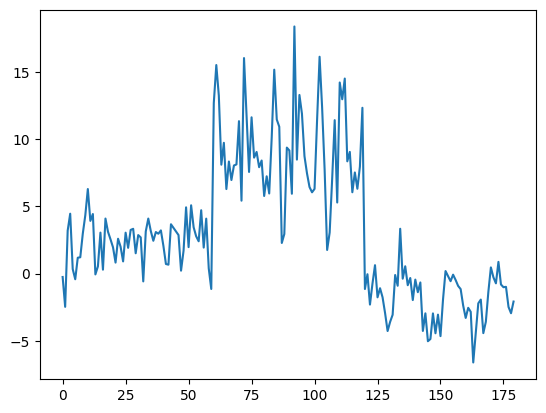

In [22]:
plt.plot(np.array(resampled_ms_validation.iloc[0,:180]))